<font size=6><b>Understand_Tables_API.ipynb:</b></font>
<p>
<font size=4>Extract Structured Information from Tables in PDF Documents
        using IBM Watson Discovery's Python SDK and Text Extensions for Pandas
</font>

# Introduction

Many organizations have valuable information hidden in tables inside human-readable documents like PDF files and web pages. Table identification and extraction technology can turn this human-readable information into a format that data science tools can import and use. Text Extensions for Pandas and Watson Discovery make this process much easier.

In this notebook, we'll follow the journey of Allison, an analyst at an investment bank. Allison's employer has assigned her to cover several different companies, one of which is IBM. As part of her analysis, Allison wants to track IBM's revenue over time, broken down by geographical region. That detailed revenue information is all there in IBM's filings with the U.S. Securities and Exchange Commission (SEC). For example, here's IBM's 2019 annual report:

![IBM Annual Report for 2019 (146 pages)](images/IBM_Annual_Report_2019.png)

Did you see the table of revenue by geography? It's here, on page 39:

![Page 39 of IBM Annual Report for 2019](images/IBM_Annual_Report_2019_page_39.png)

Here's what that table looks like close up:

![Table: Geographic Revenue (from IBM 2019 annual report)](images/screenshot_table_2019.png)

But this particular table only gives two years' revenue figures. Allison needs to have enough data to draw a meaningful chart of revenue over time. 10 years of annual revenue figures would be a good starting point. 

Allison has a collection of IBM annual reports going back to 2009. In total, these documents contain about 1500 pages of financial information. Hidden inside those 1500 pages are the detailed revenue figures that Allison wants. She needs to find those figures, extract them from the documents, and import them into her data science tools.

Fortunately, Allison has [Watson Discovery](https://www.ibm.com/cloud/watson-discovery), IBM's suite of tools for managing and extracting value from collections of human-readable documents.

The cells that follow will show how Allison uses Text Extensions for Pandas and Watson Discovery to import the detailed revenue information from her PDF documents into a Pandas DataFrame...

![Screenshot of a DataFrame from later in this notebook.](images/revenue_table.png)

...that she then uses to generate a chart of revenue over time:

![Chart of revenue over time, from later in this notebook.](images/revenue_over_time.png)

But first, let's set your environment up so that you can run Allison's code yourself.

(If you're just reading through the precomputed outputs of this notebook, you can skip ahead to the section labeled ["Extract Tables with Watson Discovery"](#watson_discovery)).

# Environment Setup

This notebook requires a Python 3.7 or later environment with the following packages:
* The dependencies listed in the ["requirements.txt" file for Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/requirements.txt)
* `matplotlib`
* `text_extensions_for_pandas`

You can satisfy the dependency on `text_extensions_for_pandas` in either of two ways:

* Run `pip install text_extensions_for_pandas` before running this notebook. This command adds the library to your Python environment.
* Run this notebook out of your local copy of the Text Extensions for Pandas project's [source tree](https://github.com/CODAIT/text-extensions-for-pandas). In this case, the notebook will use the version of Text Extensions for Pandas in your local source tree **if the package is not installed in your Python environment**.


In [1]:
# Core Python libraries
import json
import os
import sys
import requests
import glob
from typing import *
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import HTML
from base64 import b64encode

# IBM libraries
from ibm_watson import DiscoveryV2
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("notebooks"):
        raise e
    if ".." not in sys.path:
        sys.path.insert(0, "..")
    import text_extensions_for_pandas as tp

<div id="watson_discovery"/>

# Extract Tables with Watson Discovery

Allison connects to the [Watson Discovery](https://cloud.ibm.com/docs/discovery-data?topic=discovery-data-install) component of her firm's [IBM Cloud Pak for Data](https://www.ibm.com/products/cloud-pak-for-data) installation on their [OpenShift](https://www.openshift.com/) cluster and uploads her stack of IBM annual reports to her project. Then she uses the Watson Discovery's [Table Understanding enrichment](https://cloud.ibm.com/docs/discovery-data?topic=discovery-data-understanding_tables) to identify tables in the PDF documents and to extract detailed information about the cells and headers that make up each table.


You'll need two pieces of information to access your instance of Watson Discovery: An **API key** and a **service URL**. If you're using Watson Discovery on the IBM Cloud, you can find your API key and service URL in the IBM Cloud web UI. Navigate to the [resource list](https://cloud.ibm.com/resources) and click on your instance of Watson Discovery to open the management UI for your service. Then click on the "Manage" tab to show a page with your API key and service URL.

The cell that follows assumes that you are using the environment variables `IBM_API_KEY` and `IBM_SERVICE_URL` to store your credentials. If you're running this notebook in Jupyter on your laptop, you can set these environment variables while starting up `jupyter notebook` or `jupyter lab`. For example:
``` console
IBM_API_KEY='<my API key>' \
IBM_SERVICE_URL='<my service URL>' \
  jupyter lab
```
Alternately, you can uncomment the first two lines of code below to set the `IBM_API_KEY` and `IBM_SERVICE_URL` environment variables directly. **Be careful not to store your API key in any publicly-accessible location!**

In [2]:
# If you need to embed your credentials inline, uncomment the following two lines and
# paste your credentials in the indicated locations.
# os.environ["IBM_API_KEY"] = "<API key goes here>"
# os.environ["IBM_SERVICE_URL"] = "<Service URL goes here>"
# Retrieve the API key for your Watson Discovery service instance
if "IBM_API_KEY" not in os.environ:
    raise ValueError("Expected Watson Discovery api key in the environment variable 'IBM_API_KEY'")
api_key = os.environ.get("IBM_API_KEY")    
# Retrieve the service URL for your Watson Discovry service instance
if "IBM_SERVICE_URL" not in os.environ:
    raise ValueError("Expected Watson Discovery service URL in the environment variable 'IBM_SERVICE_URL'")
service_url = os.environ.get("IBM_SERVICE_URL") 

# Connect to the Watson Discovery Python API

This notebook uses the IBM Watson Python SDK to perform authentication on the IBM Cloud via the 
`IAMAuthenticator` class. See [the IBM Watson Python SDK documentation](https://github.com/watson-developer-cloud/python-sdk#iam) for more information. 

Allison starts by using the API key and service URL from the previous cell to create an instance of the
Python API for Watson Discovery.

In [3]:
authenticator = IAMAuthenticator(api_key)
version='2020-08-30'
discovery = DiscoveryV2(
    version=version,
    authenticator=authenticator
)

discovery.set_service_url(service_url)
discovery.set_disable_ssl_verification(True)

Note: This notebook shows you how to run the whole usecase end to end using the Python SDK. Alternatively, Allison could use the Watson Discovery tooling to create a project, create a collection, enable the pre-trained model to apply the Table Understanding enrichment, and add the pdf documents to the collection before querying the collection as shown in [this additional notebook](./Understand_Tables_Tooling.ipynb#watson_discovery_tooling_demo)

<div id="watson_discovery_create_project"/>

# Create a Project through the Watson Discovery Service API

She creates a new Watson Discovery project:

In [4]:
project = discovery.create_project(
        "TextExtensionsForPandasTableUnderstanding",
        "document_retrieval"
    ).get_result()
project_id = project['project_id']

/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.discovery.watson.cloud.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


# Create a Collection through the Watson Discovery Service API
She then creates a new collection in her project.

In [5]:
collection = discovery.create_collection(
        project_id = project_id,
        name = "IBM-10K"
    ).get_result()
collection_id = collection['collection_id']

/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.discovery.watson.cloud.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Before Allison can apply the table understanding to her collection, she needs to first enable the Pre-trained-models option for her collection to get the  tables annotated for her automatically using the Smart Document Understanding tool, to do so she calls following function:

In [6]:
def enable_pretrained_models(project_name:str, collection_name:str):
    auth = ("apikey", api_key)
    response = requests.get(f"{service_url}/v2/datasets?version={version}", auth=auth)
    for dataset in response.json()['datasets']:
        if (dataset['name'] ==  collection_name and 
            dataset['collections'][0]['project_name'] == project_name):
            config_id = dataset['id']
            configurations = requests.get \
            (f"{service_url}/v2/configurations/{config_id}/converters?version={version}", auth=auth).json()
            for config in configurations["converterConfigurations"]:
                if config['name'] == "ama-converter-sdu-converter":
                    config['converterSettings']['structure_model'] = 'static'
            headers = {'Content-type': 'application/json'}
            response = requests.put \
            (f"{service_url}/v2/configurations/{config_id}/converters?version={version}", \
             auth = auth, data = json.dumps(configurations), headers = headers)

enable_pretrained_models('TextExtensionsForPandasTableUnderstanding', 'IBM-10K')

Then she applies the Table Understanding enrichment to get detailed information about tables and table-related data within documents.

She should apply the enrichment only to a field that contains an HTML representation of the table. That's the only way that the enrichment can read the parts of the table, such as header rows and columns, and interpret the information in the table properly.

In [7]:
discovery.update_collection(
        project_id = project_id,
        collection_id = collection_id,
        enrichments = [{"enrichment_id": "701db916-fc83-57ab-0000-000000000012", "fields": ["html"] }]
    ).get_result()

/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.discovery.watson.cloud.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


{'name': 'IBM-10K',
 'collection_id': '8c655b3a-0ad4-3f36-0000-017eea50450a',
 'description': '',
 'created': '2022-02-11T19:43:57.451Z',
 'language': 'en',
 'enrichments': [{'enrichment_id': '701db916-fc83-57ab-0000-000000000012',
   'fields': ['html']}]}

# Pass Documents to the Watson Discovery Service API

Once she's created a collection and updated the collection with Table Understanding enrichment, she can upload the documents through 
the service by invoking the [`add_document()` method](https://cloud.ibm.com/apidocs/discovery-data?code=python#adddocument).

In [8]:
for file in glob.glob("../resources/IBM Annual Report/*.pdf"):
    with open(file,'rb') as fileinfo:
        response = discovery.add_document(
                project_id = project_id,
                collection_id = collection_id,
                file=fileinfo,
                filename=file,
                fileinfo='application/pdf'
                ).get_result()

/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.discovery.watson.cloud.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.discovery.watson.cloud.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.discovery.watson.c

<div id="watson_discovery_qury_project"/>

# Query the Project
She can then query the project with an empty string to retreive all the documents.

In [9]:
geograpies_results = discovery.query(
        project_id = project_id,
        collection_ids = [collection_id],
        natural_language_query= ""      
    ).get_result()

/Users/monireh/opt/anaconda3/envs/text-extensions-for-pandas/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.us-south.discovery.watson.cloud.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


She then searches through all the tables and keeps thoese tables which are under the "Geographic Revenue" section in the documents.

In [10]:
key = "enriched_html"
tables = [table for result in geograpies_results['results'] 
          if key in result for enriched_html in result ['enriched_html']
          for table in enriched_html['tables']
          if table['section_title']['text']=="Geographic Revenue"]
print(json.dumps(tables[0], indent=2))
print(f".\n.\n.\n {(len(tables)-1)} more tables")

{
  "section_title": {
    "location": {
      "end": 651156,
      "begin": 651138
    },
    "text": "Geographic Revenue"
  },
  "row_headers": [
    {
      "column_index_begin": 0,
      "row_index_begin": 4,
      "location": {
        "end": 656019,
        "begin": 656005
      },
      "text": "Total revenue",
      "row_index_end": 4,
      "cell_id": "rowHeader-656005-656019",
      "column_index_end": 0,
      "text_normalized": "Total revenue"
    },
    {
      "column_index_begin": 0,
      "row_index_begin": 5,
      "location": {
        "end": 657316,
        "begin": 657304
      },
      "text": "Geographies",
      "row_index_end": 5,
      "cell_id": "rowHeader-657304-657316",
      "column_index_end": 0,
      "text_normalized": "Geographies"
    },
    {
      "column_index_begin": 0,
      "row_index_begin": 6,
      "location": {
        "end": 658609,
        "begin": 658600
      },
      "text": "Americas",
      "row_index_end": 6,
      "cell_id": "rowHead

That raw output contains everything Allison needs to extract the revenue figures from this document, but it's in a format that's cumbersome to deal with. So Allison uses Text Extensions for Pandas to convert the output into a collection of Pandas DataFrames. These DataFrames encode information about the row headers, column headers, and cells that make up the table.

In [11]:
table_data = tp.io.watson.tables.parse_response({"tables":tables})
table_data.keys()

dict_keys(['row_headers', 'col_headers', 'body_cells', 'given_loc'])

In [12]:
table_data["body_cells"].head(5)

,text,column_index_begin,column_index_end,row_index_begin,row_index_end,cell_id,column_header_ids,column_header_texts,row_header_ids,row_header_texts,attributes.text,attributes.type
0,"$79,139",1,1,4,4,bodyCell-656273-656281,"[colHeader-652366-652367, colHeader-652910-652...",[2017],[rowHeader-656005-656019],[Total revenue],"[$79,139]",[Currency]
1,"$79,919",2,2,4,4,bodyCell-656529-656537,"[colHeader-652431-652432, colHeader-652975-652...",[2016],[rowHeader-656005-656019],[Total revenue],"[$79,919]",[Currency]
2,(1.0)%,3,4,4,4,bodyCell-656785-656792,"[colHeader-652496-652497, colHeader-652748-652...","[Yr.-to-Yr., Yr.-to-Yr., Percent Change, Perce...",[rowHeader-656005-656019],[Total revenue],[1.0],[Number]
3,(1.3)%,5,5,4,4,bodyCell-657040-657047,"[colHeader-652748-652759, colHeader-653497-653...","[Yr.-to-Yr., Percent Change, Adjusted for, Cur...",[rowHeader-656005-656019],[Total revenue],[1.3],[Number]
4,"$78,793",1,1,5,5,bodyCell-657571-657579,"[colHeader-652366-652367, colHeader-652910-652...",[2017],[rowHeader-657304-657316],[Geographies],"[$78,793]",[Currency]


Text Extensions for Pandas can convert these DataFrames into a single Pandas DataFrame that matches the layout of the original table in the document. Allison calls the `make_table()` function to perform that conversion and inspects the output.

In [13]:
revenue_2017_df = tp.io.watson.tables.make_table(table_data)
revenue_2017_df

Yr.-to-Yr.
                                                Yr.-to-Yr. Percent Change
                                                Yr.-to-Yr.   Adjusted for
                              2017     2016 Percent Change       Currency
                                                   Percent               
                                                                         
                                                    Change               
                                                                         
Total revenue              $79,139  $79,919         (1.0)%         (1.3)%
Geographies                $78,793  $79,594         (1.0)%         (1.4)%
Americas                     37479    37513           -0.1           -0.6
Europe/Middle East/Africa    24345    24769           -1.7           -2.8
Asia Pacific                 16970    17313             -2           -1.1

&nbsp;  

The reconstructed dataframe looks good! Here's what the original table in the PDF document looked like:
![Table: Geographic Revenue (from IBM 2017 annual report)](images/screenshot_table_2017.png)

If Allison just wanted to create a DataFrame of 2016/2017 revenue figures, her task would be done. But Allison wants to reconstruct ten years of revenue by geographic region. To do that, she will need to combine information from multiple documents. For tables like this one that have multiple levels of header information, this kind of integration is easier to perform over the "exploded" version of the table, where each cell in the table is represented a single row containing all the corresponding header values.

Allison passes the same table data from the 2017 report through the Text Extensions for Pandas function `make_exploded_df()` to produce the exploded represention of the table:

In [14]:
exploded_df, row_header_names, col_header_names = (
    tp.io.watson.tables.make_exploded_df(table_data, col_explode_by="concat"))
exploded_df

,text,row_header_texts_0,column_header_texts,attributes.type
0,"$79,139",Total revenue,2017,[Currency]
1,"$79,919",Total revenue,2016,[Currency]
2,(1.0)%,Total revenue,Yr.-to-Yr. Yr.-to-Yr. Percent Change Percent C...,[Number]
3,(1.3)%,Total revenue,Yr.-to-Yr. Percent Change Adjusted for Currency,[Number]
4,"$78,793",Geographies,2017,[Currency]
5,"$79,594",Geographies,2016,[Currency]
6,(1.0)%,Geographies,Yr.-to-Yr. Yr.-to-Yr. Percent Change Percent C...,[Number]
7,(1.4)%,Geographies,Yr.-to-Yr. Percent Change Adjusted for Currency,[Number]
8,"37,479",Americas,2017,[Number]
9,"37,513",Americas,2016,[Number]


This exploded version of the table is the exact same data, just represented in a different way. If she wants, Allison can convert it back to the format from the original document by calling `pandas.DataFrame.pivot()`:

In [15]:
exploded_df.pivot(index="row_header_texts_0", columns="column_header_texts", values="text")

column_header_texts,2016,2017,Yr.-to-Yr. Percent Change Adjusted for Currency,Yr.-to-Yr. Yr.-to-Yr. Percent Change Percent Change
row_header_texts_0,,,,
Americas,"37,513","37,479",(0.6),(0.1)
Asia Pacific,"17,313","16,970",(1.1),(2.0)
Europe/Middle East/Africa,"24,769","24,345",(2.8),(1.7)
Geographies,"$79,594","$78,793",(1.4)%,(1.0)%
Total revenue,"$79,919","$79,139",(1.3)%,(1.0)%


But because she is about to merge this DataFrame with similar data from other documents, Allison keeps the data in exploded format for now. 

Allison's next task is to write some Pandas transformations that will clean and reformat the DataFrame for each source table prior to merging them all together. She uses the 2017 report's data as a test case for creating this code. The first step is to convert the cell values in the Watson Discovery output from text to numeric values. Text Extensions for Pandas includes a more robust version of [`pandas.to_numeric()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html) that can handle common idioms for representing currencies and percentages. Allison uses this function, called `convert_cols_to_numeric()`, to convert all the cell values to numbers. She adds a new column "value" to her DataFrame to hold these numbers.

In [16]:
exploded_df["value"] = \
    tp.io.watson.tables.convert_cols_to_numeric(exploded_df[["text"]])
exploded_df

,text,row_header_texts_0,column_header_texts,attributes.type,value
0,"$79,139",Total revenue,2017,[Currency],79139.0
1,"$79,919",Total revenue,2016,[Currency],79919.0
2,(1.0)%,Total revenue,Yr.-to-Yr. Yr.-to-Yr. Percent Change Percent C...,[Number],-1.0
3,(1.3)%,Total revenue,Yr.-to-Yr. Percent Change Adjusted for Currency,[Number],-1.3
4,"$78,793",Geographies,2017,[Currency],78793.0
5,"$79,594",Geographies,2016,[Currency],79594.0
6,(1.0)%,Geographies,Yr.-to-Yr. Yr.-to-Yr. Percent Change Percent C...,[Number],-1.0
7,(1.4)%,Geographies,Yr.-to-Yr. Percent Change Adjusted for Currency,[Number],-1.4
8,"37,479",Americas,2017,[Number],37479.0
9,"37,513",Americas,2016,[Number],37513.0


Now all the cell values have been converted to floating-point numbers, but only some of these numbers represent revenue. Looking at the 2017 data, Allison can see that the revenue numbers have 4-digit years in their column headers. So she filters the DataFrame down to just those rows with 4-digit numbers in the "column_header_texts" column.

In [17]:
rows_to_retain = exploded_df[((exploded_df["column_header_texts"].str.fullmatch("\d{4}"))) &
                             (exploded_df["text"].str.len() > 0)].copy()
rows_to_retain

,text,row_header_texts_0,column_header_texts,attributes.type,value
0,"$79,139",Total revenue,2017,[Currency],79139.0
1,"$79,919",Total revenue,2016,[Currency],79919.0
4,"$78,793",Geographies,2017,[Currency],78793.0
5,"$79,594",Geographies,2016,[Currency],79594.0
8,"37,479",Americas,2017,[Number],37479.0
9,"37,513",Americas,2016,[Number],37513.0
12,"24,345",Europe/Middle East/Africa,2017,[Number],24345.0
13,"24,769",Europe/Middle East/Africa,2016,[Number],24769.0
16,"16,970",Asia Pacific,2017,[Number],16970.0
17,"17,313",Asia Pacific,2016,[Number],17313.0


That's looking good! Now Allison drops the unnecessary columns and gives some more friendly names to the columns that remain.

In [18]:
rows_to_retain.rename(
    columns={
        "row_header_texts_0": "Region",
        "column_header_texts": "Year",
        "value": "Revenue"
    })[["Year", "Region", "Revenue"]]

,Year,Region,Revenue
0,2017,Total revenue,79139.0
1,2016,Total revenue,79919.0
4,2017,Geographies,78793.0
5,2016,Geographies,79594.0
8,2017,Americas,37479.0
9,2016,Americas,37513.0
12,2017,Europe/Middle East/Africa,24345.0
13,2016,Europe/Middle East/Africa,24769.0
16,2017,Asia Pacific,16970.0
17,2016,Asia Pacific,17313.0


The code from the last few cells worked to clean up the 2017 data, so Allison copies and pastes that code into a Python function:

In [19]:
def dataframe_for_table(table: str):

    table_data = tp.io.watson.tables.parse_response({"tables":[table]})
    exploded_df, _, _ = tp.io.watson.tables.make_exploded_df(
        table_data, col_explode_by="concat")
    
    if "column_header_texts" in exploded_df.columns and "row_header_texts_0" in exploded_df.columns:    
        rows_to_retain = exploded_df[((exploded_df["column_header_texts"].str.fullmatch("\d{4}"))
                                       & (exploded_df["text"].str.len() > 0)
                                     )].copy()
        rows_to_retain["value"] = tp.io.watson.tables.convert_cols_to_numeric(
            rows_to_retain[["text"]])
        rows_to_retain["file"] = "filename"
        return (
            rows_to_retain.rename(columns={
                "row_header_texts_0": "Region", "column_header_texts": "Year", "value": "Revenue"})
            [["Year", "Region", "Revenue"]]
        )


Then she calls that function on the Watson Discovery output from the 2017 annual report to verify that it produces the same answer. 

In [20]:
dataframe_for_table(tables[0])

,Year,Region,Revenue
0,2017,Total revenue,79139.0
1,2016,Total revenue,79919.0
4,2017,Geographies,78793.0
5,2016,Geographies,79594.0
8,2017,Americas,37479.0
9,2016,Americas,37513.0
12,2017,Europe/Middle East/Africa,24345.0
13,2016,Europe/Middle East/Africa,24769.0
16,2017,Asia Pacific,16970.0
17,2016,Asia Pacific,17313.0


Looks good! Time to run the same function over an entire stack of reports.

Allison calls her `dataframe_for_table()` function on each of the tables, then concatenates all of the resulting Pandas DataFrames into a single large DataFrame.

In [21]:
revenue_df = pd.concat([dataframe_for_table(t) for t in tables])
revenue_df

,Year,Region,Revenue
0,2017,Total revenue,79139.0
1,2016,Total revenue,79919.0
4,2017,Geographies,78793.0
5,2016,Geographies,79594.0
8,2017,Americas,37479.0
...,...,...,...
17,2009,Asia Pacific,20710.0
0,2018,Total revenue,79591.0
5,2018,Americas,36994.0
9,2018,Europe/Middle East/Africa,25491.0


Allison can see that the first four lines of this DataFrame contain total worldwide revenue; and that this total occurred
under different names in different documents. Allison is interested in the fine-grained revenue figures, not
the totals, so she needs to filter out all these rows with worldwide revenue.

What are all the names of geographic regions that IBM annual reports have used over the last ten years?

In [22]:
revenue_df[["Region"]].drop_duplicates()

,Region
0,Total revenue
4,Geographies
8,Americas
12,Europe/Middle East/Africa
16,Asia Pacific
0,Total revenue:
4,Geographies:
9,2009. The increase in total expense and other ...
25,Examples of the company's investments include:
29,NaN


It looks like all the worldwide revenue figures are under some variation of "Geographies" or "Total revenue". 
Allison uses Pandas' string matching facilities to keep the rows whose "Region" column contains the 
name of the regions in the world.

In [23]:
geo_revenue_df = (
    revenue_df[(
        (revenue_df["Region"].str.contains("Americas", case=False))
        | (revenue_df["Region"].str.contains("Europe/Middle East/Africa", case=False))
        | (revenue_df["Region"].str.contains("Asia Pacifi", case=False))
    )]).copy()
geo_revenue_df

,Year,Region,Revenue
8,2017,Americas,37479.0
9,2016,Americas,37513.0
12,2017,Europe/Middle East/Africa,24345.0
13,2016,Europe/Middle East/Africa,24769.0
16,2017,Asia Pacific,16970.0
...,...,...,...
16,2010,Asia Pacific,23150.0
17,2009,Asia Pacific,20710.0
5,2018,Americas,36994.0
9,2018,Europe/Middle East/Africa,25491.0


Now every row contains a regional revenue figure. What are the regions represented? 

In [24]:
geo_revenue_df[["Region"]].drop_duplicates()

,Region
8,Americas
12,Europe/Middle East/Africa
16,Asia Pacific
16,Asia Pacifi c


That's strange &mdash; one of the regions is "Asia Pacifi c", with a space before the last "c". It looks like the PDF conversion on the 2016 annual report added an extra space. Allison uses the function `pandas.Series.replace()` to correct that issue.

In [25]:
geo_revenue_df["Region"] = geo_revenue_df["Region"].replace("Asia Pacifi c", "Asia Pacific")
geo_revenue_df

,Year,Region,Revenue
8,2017,Americas,37479.0
9,2016,Americas,37513.0
12,2017,Europe/Middle East/Africa,24345.0
13,2016,Europe/Middle East/Africa,24769.0
16,2017,Asia Pacific,16970.0
...,...,...,...
16,2010,Asia Pacific,23150.0
17,2009,Asia Pacific,20710.0
5,2018,Americas,36994.0
9,2018,Europe/Middle East/Africa,25491.0


Allison inspects the time series of revenue for the "Americas" region:

In [26]:
geo_revenue_df[geo_revenue_df["Region"] == "Americas"].sort_values("Year")

,Year,Region,Revenue
9,2008,Americas,42807.0
9,2009,Americas,40184.0
8,2009,Americas,40184.0
9,2009,Americas,40184.0
8,2010,Americas,42044.0
9,2010,Americas,42044.0
8,2010,Americas,42044.0
9,2010,Americas,42044.0
8,2011,Americas,44944.0
8,2011,Americas,44944.0


Every year from 2008 to 2019 is present, but many of the years appear multiple times. That's to be expected, 
since each of the annual reports contains two years of geographical revenue figures and some of the annual reports contain two tables.
Allison  drops the duplicate values using `pandas.DataFrame.drop_duplicates()`.

In [27]:
geo_revenue_df.drop_duplicates(["Region", "Year"], inplace=True)
geo_revenue_df

,Year,Region,Revenue
8,2017,Americas,37479.0
9,2016,Americas,37513.0
12,2017,Europe/Middle East/Africa,24345.0
13,2016,Europe/Middle East/Africa,24769.0
16,2017,Asia Pacific,16970.0
17,2016,Asia Pacific,17313.0
9,2015,Americas,38486.0
13,2015,Europe/Middle East/Africa,26073.0
17,2015,Asia Pacific,16871.0
8,2010,Americas,42044.0


Now Allison has a clean and complete set of revenue figures by geographical region for the years 2008-2019.
She uses Pandas' `pandas.DataFrame.pivot()` method to convert this data into a compact table.

In [28]:
revenue_table = geo_revenue_df.pivot(index="Region", columns="Year", values="Revenue")
revenue_table

Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Region,,,,,,,,,,,
Americas,42807.0,40184.0,42044.0,44944.0,44556.0,43249.0,41410.0,38486.0,37513.0,37479.0,36994.0
Asia Pacific,21111.0,20710.0,23150.0,25273.0,25937.0,22923.0,20216.0,16871.0,17313.0,16970.0,17106.0
Europe/Middle East/Africa,37020.0,32583.0,31866.0,33952.0,31775.0,31628.0,30700.0,26073.0,24769.0,24345.0,25491.0


Then she uses that table to produce a plot of revenue by region over that 11-year period.

<AxesSubplot:title={'center':'Revenue by Geographic Region'}, xlabel='Year', ylabel='Revenue (Millions of US$)'>

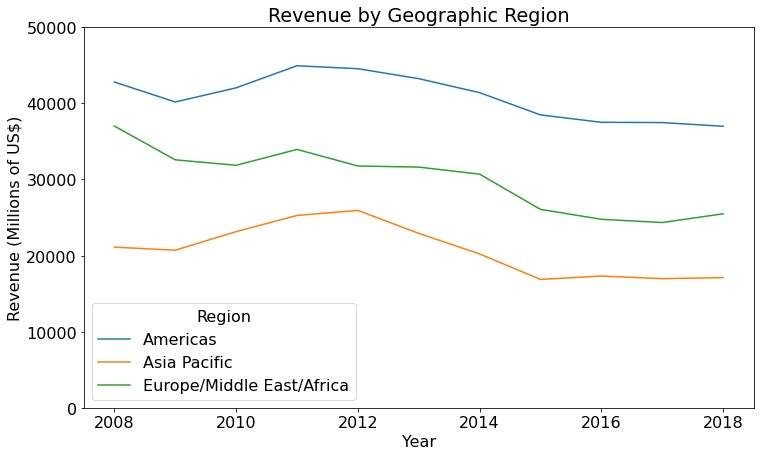

In [29]:
plt.rcParams.update({'font.size': 16})
revenue_table.transpose().plot(title="Revenue by Geographic Region",
                               ylabel="Revenue (Millions of US$)",
                               figsize=(12, 7), ylim=(0, 50000))

Now Allison has a clear picture of the detailed revenue data that was hidden inside those 1500 pages of PDF
files. As she works on her analyst report, Allison can use the same process to extract DataFrames for
other financial metrics too!